# 과제 10

- GEE를 이용하여 NDVI를 영상을 생성하여 표출하시오.
- 시계열 그래프로 변화양상을 표현하시오. Ex) 월별변화, 연간 변화 등

In [27]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (34.0 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121913 files and direc

In [1]:
# !pip install ffmpeg-python

In [1]:
import geemap
import json
import os
from datetime import datetime
import calendar
import ee
import requests
import pandas as pd
from geemap import geojson_to_ee, ee_to_geojson
from ipyleaflet import GeoJSON, Marker, MarkerCluster, Popup
import ipywidgets as widgets
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates as mdates

In [2]:
ee.Authenticate()
ee.Initialize()

## 1. Earth Engine & NDVI

### 1. Scale

In [3]:
def apply_scale_factors(image, img_key):
    if 'landsat' in img_key:
        optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
        thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
        return image.addBands(optical_bands, None, True).addBands(thermal_bands, None, True)
    elif 'sentinel' in img_key:
        return image.divide(10000)

### 2. Mask Clouds

- 구름과 구름 그림자가 제거된 깨끗한 이미지를 얻음.
- 구름 및 구름 그림자가 있는 픽셀을 마스크 처리하면 마스크 처리된 픽셀은 계산에서 제외되기 때문에 데이터에서 결측이 발생할 수 있음.
- 특히 구름이 많거나 강수량이 많은 시기에 흔히 발생할 수 있음.

In [4]:
def mask_clouds(image, img_key):
    if 'landsat' in img_key:
        cloud_shadow_bit_mask = 1 << 3 # 구름 그림자
        clouds_bit_mask = 1 << 5       # 구름

        qa = image.select('QA_PIXEL')

        mask = (qa.bitwiseAnd(cloud_shadow_bit_mask).eq(0)
                .And(qa.bitwiseAnd(clouds_bit_mask).eq(0)))

        return image.updateMask(mask)
    else:
        qa = image.select('QA60')

        cloud_bit_mask = 1 << 10   # 구름
        cirrus_bit_mask = 1 << 11  # 성층운

        mask = (qa.bitwiseAnd(cloud_bit_mask).eq(0)
                .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0)))

        return image.updateMask(mask)

### 3. NDVI

$$ NDVI = \frac {(NIR - RED)} {(NIR + RED)}$$

In [5]:
def add_NDVI(image, img_key):
    if 'landsat' in img_key:
        band = ['SR_B5', 'SR_B4']
    else:
        band = ['B8', 'B4']
    return image.addBands(image.normalizedDifference(band).rename('NDVI'))


### 4. reduceToMean
- 위성 이미지의 특정 밴드에 대해 지정된 지역(site)의 평균 값을 계산하는 작업

In [6]:
def reduceToMean(image, site, band_name, img_key):
    if 'landsat' in img_key:
        scale = 30
    else:
        scale = 10
    return image.select(band_name).reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=site,
        scale=scale,
        maxPixels=1e9
    ).get(band_name)

In [7]:
def extract_properties(image, site, sel_bands, img_key):
    return {band_name: reduceToMean(image, site, band_name, img_key) for band_name in sel_bands}

### 5. 위성영상 처리

In [8]:
def processing_collection(start_date, end_date, collection, site, img_key):
    if 'sentinel' in img_key:
        cloud_band = 'CLOUDY_PIXEL_PERCENTAGE'
    else:
        cloud_band = 'CLOUD_COVER'
    processed_collection = (collection
                            .filterDate(start_date, end_date)                        # 원하는 기간만 필터링
                            .filterBounds(site)                                      # 원하는 지역만 필터링
                            .map(lambda image: mask_clouds(image, img_key))          # mask_clouds 적용
                            # .filter(ee.Filter.lt(cloud_band, 20))                    # 구름양이 20 이하인 이미지만 필터링
                            .map(lambda image: apply_scale_factors(image, img_key))  # apply_scale_factors 적용
                            .map(lambda image: add_NDVI(image, img_key))             # add_NDVI 적용
                            )
    return processed_collection

### 6. 처리 후 위성영상의 features를 데이터프레임으로

In [9]:
def images2features(images, site, sel_bands, img_key):
    if 'landsat' in img_key:
        return images.map(
            lambda image: ee.Feature(None, {'date': ee.Date(image.get('system:time_start')).format('YYYY-MM-dd'),
                                            **extract_properties(image, site, sel_bands, img_key)})).getInfo()
    else:
        return images.map(lambda image: ee.Feature(None, extract_properties(image, site, sel_bands, img_key))).getInfo()


In [10]:
def collection2dataframe(start_date, end_date, collection, site, img_key):

    # sel_bands = ['NDVI', 'CLOUD']
    sel_bands = ['NDVI']
    processed_collection = processing_collection(start_date, end_date, collection, site, img_key)
    features = images2features(processed_collection, site, sel_bands, img_key)
    data = []
    for feature in features['features']:
        if 'landsat' in img_key:
            pro = feature['properties']
        else:
            pro = feature['properties']
            pro['date'] = datetime.strptime(feature['id'][:8], "%Y%m%d").strftime("%Y-%m-%d")
        data.append(pro)

    df = pd.DataFrame(data)
    df['satellite'] = img_key
    df = df[['date', 'NDVI', 'satellite']]
    return df

### 7. 기간과 지역을 설정하고 위의 작업 수행

<img width="399" alt="img" src="https://github.com/jungjae0/jungjae0/assets/93760723/5318f505-022e-4f34-9dff-e4ac73b402b0">


In [11]:
start_date = '2019-01-01'
end_date = '2023-12-31'
satellite_dct = {
    'sentinel2': (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")),
    'landsat8': ee.ImageCollection("LANDSAT/LC08/C02/T1_L2"),
}
roi = ee.Geometry.MultiPolygon(
    [[[
        [126.83344314831722, 35.69853080347812],
        [126.83401177662837, 35.69946743167022],
        [126.83303008812892, 35.69985079259434],
        [126.83244000214565, 35.69893595097654],
        [126.83344314831722, 35.69853080347812],
    ]]])

data = [collection2dataframe(start_date, end_date, collection, roi, img_key) for img_key, collection in satellite_dct.items()]

df = pd.concat(data, ignore_index=True)

In [26]:
timelapse = geemap.sentinel2_timelapse(
    roi,
    out_gif='sentinel2.gif',
    start_year=2019,
    end_year=2023,
    start_date='01-01',
    end_date='12-31',
    frequency='year',
    bands=['SWIR1', 'NIR', 'Red'],
    frames_per_second=3,
    title='NDVI',
    progress_bar_color="blue",
    mp4=True,
)
geemap.show_image(timelapse)

Generating URL...
Please wait ...
The GIF image has been saved to: /content/sentinel2.gif


Output()

## 2. 변화양상

In [13]:
df['date'] = pd.to_datetime(df['date'])
df = df[df['NDVI'] > 0]
df = df.sort_values(by='date')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['year_month'] = df['date'].dt.strftime('%Y-%m')

### 1. 해당 기간에 NDVI 값이 연속적으로 존재하는지 확인
cloud mask 작업으로 결측이 발생함.

In [14]:
def check_existence(df, item):
    start_date = '2019-01'
    end_date = '2023-12'
    date_range = pd.date_range(start=start_date, end=end_date, freq='MS')
    year_month_list = date_range.strftime('%Y-%m').tolist()

    satellite = df[df['satellite'] == item]
    satellite = satellite.dropna(subset=['NDVI'])
    satellite = satellite[satellite['NDVI'] > 0]
    data_year_month_list = satellite['year_month'].astype(str).unique()

    set_real = set(year_month_list)
    set_data = set(data_year_month_list)
    real_data = set_real - set_data
    data_real = set_data - set_real

    unique_values = list(real_data) + list(data_real)
    print(f'{item}\n{unique_values}')

In [15]:
for item in df['satellite'].unique():
  check_existence(df, item)

sentinel2
[]
landsat8
['2019-03', '2021-01', '2021-05', '2023-12', '2022-07', '2022-08', '2020-01']


### 2. 월별/연도별 평균



In [16]:
group_dct = {'year': ['year'], 'year_month': ['year', 'month']}

group_df_dct = {}
for key, group_item in group_dct.items():
    df = df.dropna(subset=['NDVI'])
    mean_df = df.groupby(group_item + ['satellite'])['NDVI'].mean().reset_index()
    all_df = mean_df.groupby(group_item)['NDVI'].mean().reset_index()
    all_df['satellite'] = 'all'
    result = pd.concat([all_df, mean_df])
    group_df_dct[key] = result

In [17]:
yearly_df = group_df_dct['year']
yearly_df['year'] = yearly_df['year'].astype(str)
yearly_df

,year,NDVI,satellite
0,2019,0.451188,all
1,2020,0.500727,all
2,2021,0.506985,all
3,2022,0.337117,all
4,2023,0.392254,all
0,2019,0.485293,landsat8
1,2019,0.417082,sentinel2
2,2020,0.520856,landsat8
3,2020,0.480598,sentinel2
4,2021,0.555592,landsat8


In [18]:
monthly_df = group_df_dct['year_month']
monthly_df['year_month'] = monthly_df.apply(lambda row: f"{row['year']}-{row['month']:02d}", axis=1)
monthly_df

,year,month,NDVI,satellite,year_month
0,2019,1,0.326088,all,2019-01
1,2019,2,0.301323,all,2019-02
2,2019,3,0.375161,all,2019-03
3,2019,4,0.590431,all,2019-04
4,2019,5,0.748194,all,2019-05
...,...,...,...,...,...
108,2023,10,0.390918,landsat8,2023-10
109,2023,10,0.315749,sentinel2,2023-10
110,2023,11,0.232705,landsat8,2023-11
111,2023,11,0.128217,sentinel2,2023-11


### 3. 월별/연도별 시계열 그래프를 그림

In [19]:
plt.rc('font', family='NanumGothic')  # 사용할 한글 폰트 설정

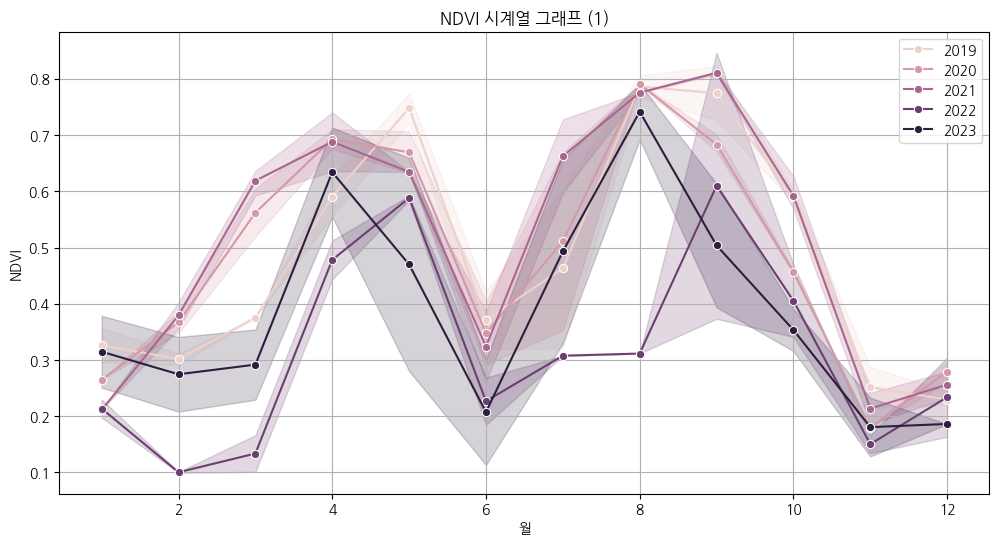

In [20]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_df, x='month', y='NDVI', hue='year', marker='o')

plt.title('NDVI 시계열 그래프 (1)')
plt.xlabel('월')
plt.ylabel('NDVI')
plt.grid(True)
plt.legend()
plt.show()

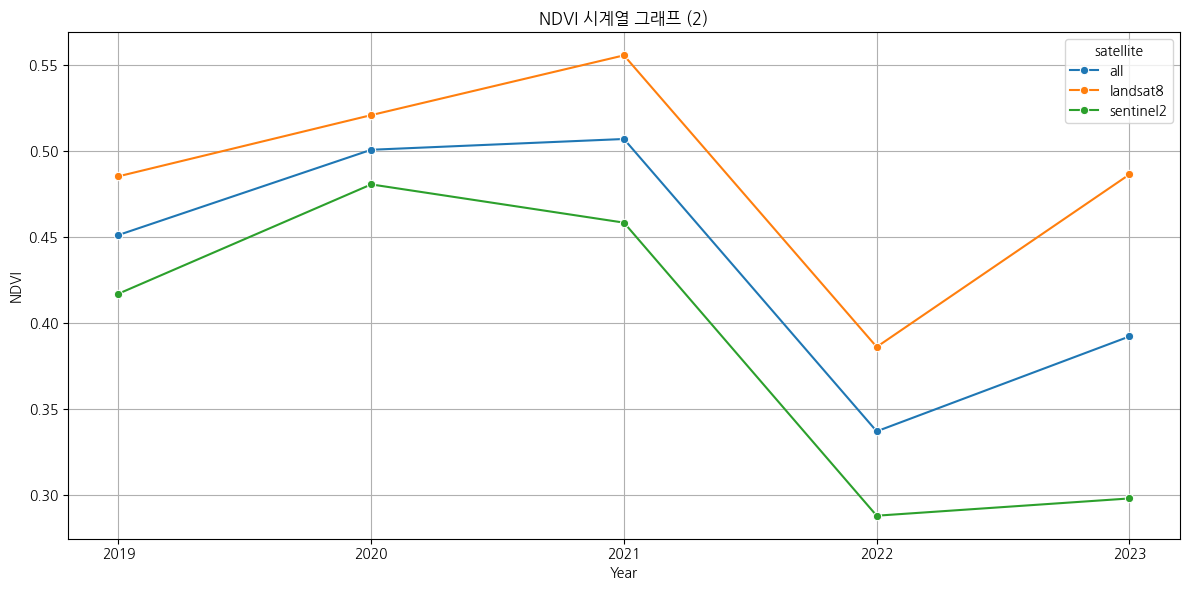

In [21]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=yearly_df, x='year', y='NDVI', hue='satellite', marker='o')

plt.title('NDVI 시계열 그래프 (2)')
plt.xlabel('Year')
plt.ylabel('NDVI')

plt.grid(True)
plt.tight_layout()
plt.show()

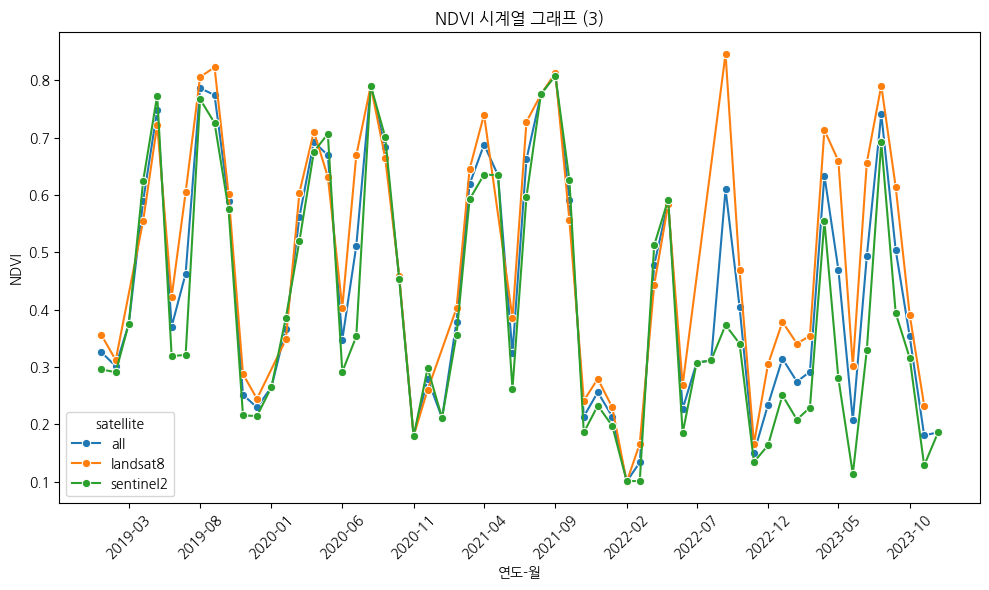

In [22]:
plt.figure(figsize=(10, 6))
monthly_df['year_month'] = pd.to_datetime(monthly_df['year_month'])

# Seaborn의 lineplot을 사용하여 시간에 따른 NDVI의 추이를 그림
sns.lineplot(data=monthly_df, x='year_month', y='NDVI', hue='satellite', marker='o')

# 그래프 제목과 축 레이블 설정
plt.title('NDVI 시계열 그래프 (3)')
plt.xlabel('연도-월')
plt.ylabel('NDVI')

# x 축 레이블 설정
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

# 그래프 출력
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

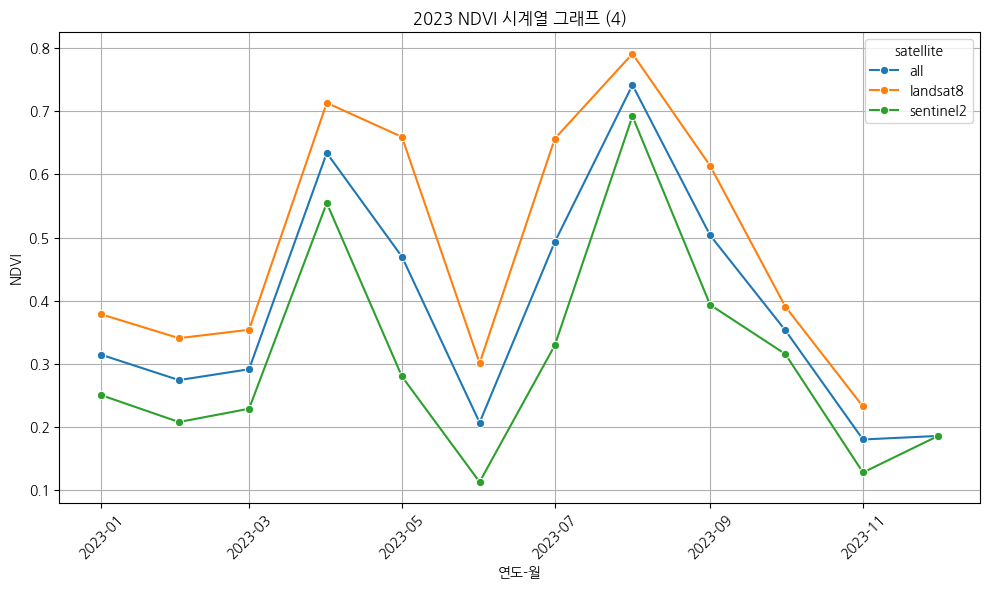

In [23]:
plt.figure(figsize=(10, 6))
df_2023 = monthly_df[monthly_df['year'] == 2023]

# Seaborn의 lineplot을 사용하여 시간에 따른 NDVI의 추이를 그림
sns.lineplot(data=df_2023, x='year_month', y='NDVI', hue='satellite', marker='o')

# 그래프 제목과 축 레이블 설정
plt.title('2023 NDVI 시계열 그래프 (4)')
plt.xlabel('연도-월')
plt.ylabel('NDVI')

# 그래프 출력
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
df_2023

,year,month,NDVI,satellite,year_month
48,2023,1,0.314614,all,2023-01-01
49,2023,2,0.274479,all,2023-02-01
50,2023,3,0.291662,all,2023-03-01
51,2023,4,0.634019,all,2023-04-01
52,2023,5,0.469825,all,2023-05-01
53,2023,6,0.207220,all,2023-06-01
54,2023,7,0.493064,all,2023-07-01
55,2023,8,0.741620,all,2023-08-01
56,2023,9,0.503683,all,2023-09-01
57,2023,10,0.353334,all,2023-10-01


연도별로 2번 같은 패턴이 반복되는 것으로 보아 이모작을 하는 곳으로 추측.


#### 2022년
- 그래프 (2)를 보면 2022년을 제외하고는 비슷한 값을 보이지만, 2022년이 유난히 낮음.
- 그래프 (1)을 보면 2022년의 7-8월 값이 다른 해에 비해 낮음.
- 2022년 가뭄이 심했던 것을 기사를 통해 확인함.

<img width="952" alt="img" src="https://github.com/jungjae0/jungjae0/assets/93760723/252b11da-bb06-45a1-b660-0213c6f30855">

출처:[https://news.kbs.co.kr/news/pc/view/view.do?ncd=7581930](https://news.kbs.co.kr/news/pc/view/view.do?ncd=7581930)


#### 2023년
- 그래프 (2)를 보면 다른 해에 비해 2023년에 Landsat8과 Sentinel2의 평균값 차이가 큼.
- 2023년의 5-8월 표를 확인해 Sentinel2로부터 얻은 NDVI 값이 낮은 날들의 기상을 찾아봄.
- 2023년 5월 7일, 12일과 2023년 7월 6일, 16일의 과거관측 일별자료에서 비가 왔거나, 평균 운량이 높은 것을 확인.
- 관측일의 운량, 강수량 등 복합적인 영향이 있었을 것으로 생각됨.

<img width="1207" alt="img" src="https://github.com/jungjae0/jungjae0/assets/93760723/df17b75f-4840-41ba-b6b6-8ccc74c3ce9e">
<img width="1241" alt="img" src="https://github.com/jungjae0/jungjae0/assets/93760723/d99990c2-3c82-4201-b8ba-ea317617b02c">

출처: [https://www.weather.go.kr/w/obs-climate/land/past-obs/obs-by-day.do?stn=243&yy=2023&mm=5&obs=1](https://www.weather.go.kr/w/obs-climate/land/past-obs/obs-by-day.do?stn=243&yy=2023&mm=5&obs=1)